Copyright &copy; 2015 Ondrej Martinsky, All rights reserved

[www.quantandfinancial.com](http://www.quantandfinancial.com)
# Heath Jarrow Morton Model (HJM)

### Initialize libraries and define functions

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import copy as copylib
from progressbar import *
%pylab
%matplotlib inline
import pandas
pylab.rcParams['figure.figsize'] = (16, 4.5)
numpy.random.seed(0)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Load Historical Data
Loads historical short-rate curves $f(t,\tau)$ from the file.
$f(t, \tau)$ represents instantenous forward rate for period $\tau \rightarrow \tau + \delta$, locked in time $t$. This rates can be obtained from prices of zero-coupons bond as:
$$ f(t, \tau) = \frac{\delta}{\delta \tau} log P(t, \tau)$$ 

In [2]:
dataframe =  pandas.DataFrame.from_csv('hjm_data.csv')
dataframe = dataframe / 100 # Convert interest rates to %
pandas.options.display.max_rows = 10
display(dataframe)

,0.08333333000000,0.50000000000000,1.00000000000000,1.50000000000000,2.00000000000000,2.50000000000000,3.00000000000000,3.50000000000000,4.00000000000000,4.50000000000000,...,20.50000000000000,21.00000000000000,21.50000000000000,22.00000000000000,22.50000000000000,23.00000000000000,23.50000000000000,24.00000000000000,24.50000000000000,25.00000000000000
Tenor,,,,,,,,,,,,,,,,,,,,,
1.0,0.057734,0.064382,0.067142,0.066512,0.064991,0.063255,0.061534,0.059925,0.058444,0.057058,...,0.034194,0.034772,0.035371,0.035985,0.036612,0.037252,0.037902,0.038562,0.039231,0.039908
2.0,0.057680,0.064506,0.067502,0.066842,0.065423,0.063852,0.062301,0.060846,0.059490,0.058198,...,0.033790,0.034437,0.035108,0.035798,0.036504,0.037224,0.037959,0.038705,0.039461,0.040227
3.0,0.057758,0.064410,0.067354,0.066845,0.065577,0.064109,0.062611,0.061164,0.059782,0.058438,...,0.032706,0.033294,0.033907,0.034539,0.035188,0.035853,0.036533,0.037224,0.037927,0.038639
4.0,0.057430,0.064103,0.066942,0.066215,0.064904,0.063462,0.062006,0.060601,0.059252,0.057933,...,0.031325,0.031891,0.032486,0.033106,0.033748,0.034409,0.035088,0.035784,0.036493,0.037214
5.0,0.057412,0.063978,0.066358,0.065502,0.064168,0.062722,0.061262,0.059849,0.058488,0.057157,...,0.030119,0.030667,0.031250,0.031862,0.032499,0.033161,0.033844,0.034546,0.035264,0.035997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260.0,0.046421,0.045093,0.042471,0.042081,0.042663,0.043224,0.043640,0.043940,0.044156,0.044314,...,0.040260,0.040098,0.039950,0.039813,0.039687,0.039571,0.039464,0.039365,0.039273,0.039187
1261.0,0.046233,0.044976,0.042452,0.042131,0.042726,0.043285,0.043699,0.043998,0.044214,0.044374,...,0.040307,0.040147,0.039999,0.039863,0.039737,0.039621,0.039514,0.039414,0.039320,0.039233
1262.0,0.046348,0.045311,0.043295,0.043266,0.043963,0.044565,0.045003,0.045323,0.045560,0.045739,...,0.041276,0.041118,0.040972,0.040840,0.040718,0.040607,0.040505,0.040411,0.040324,0.040244


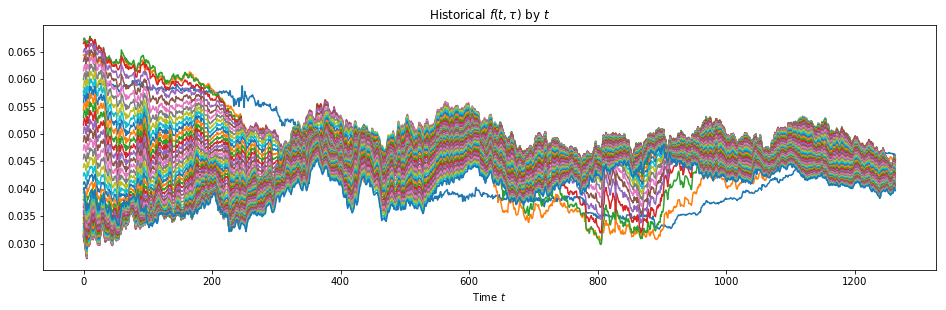

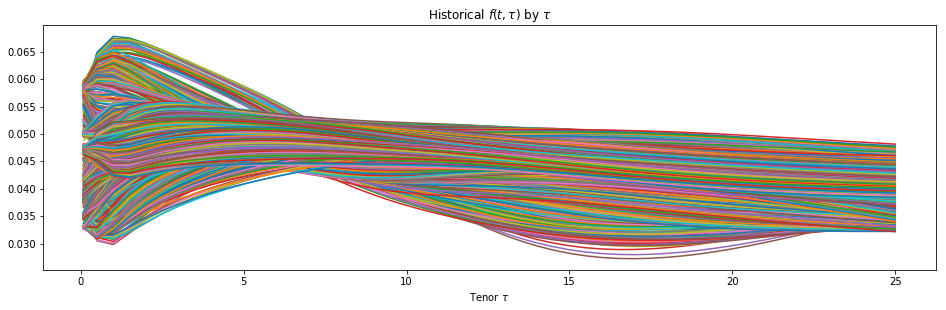

In [3]:
hist_timeline = list(dataframe.index)
tenors = [float(x) for x in dataframe.columns]
hist_rates = matrix(dataframe)
plot(hist_rates), xlabel(r'Time $t$'), title(r'Historical $f(t,\tau)$ by $t$'), show()
plot(tenors, hist_rates.transpose()), xlabel(r'Tenor $\tau$'), title(r'Historical $f(t,\tau)$ by $\tau$');

### Differentiate historical rates
Differentiate matrix of historical rates by $t$

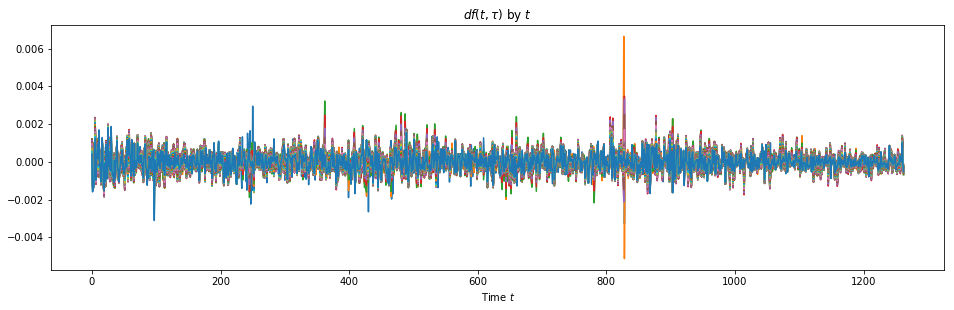

In [4]:
diff_rates = diff(hist_rates, axis=0)
assert(hist_rates.shape[1]==diff_rates.shape[1])
plot(diff_rates), xlabel(r'Time $t$'), title(r'$df(t,\tau)$ by $t$');

### Principal component analysis
Extract principal components from the $df(t,\tau)$

In [5]:
# Calculate covariance matrix
sigma = cov(diff_rates.transpose())
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (51, 51)


##### Source data are daily rates, therefore annualize covariance matrix

In [6]:
sigma *= 252

#### Calculate eigenvalues and eigenvectors

In [7]:
eigval, eigvec = linalg.eig(sigma)
eigvec=matrix(eigvec)
assert type(eigval) == ndarray
assert type(eigvec) == matrix
print(eigval)

[  2.02884026e-03   4.62889282e-04   1.63677691e-04   8.47948767e-05
   5.10134525e-05   3.26491422e-05   1.53862297e-05   3.90765854e-06
   1.45385608e-06   3.99451240e-07   7.74123143e-08   2.25094249e-08
   6.81015623e-09   2.04941470e-09   8.30654931e-10   3.18422195e-10
   1.69855214e-10   1.20686738e-10   8.18818617e-11   4.65678092e-11
   2.41691461e-11   1.26818403e-11   7.83625329e-12   4.07032931e-12
   2.61696283e-12   1.78998712e-12   1.07235664e-12   6.26516007e-13
   3.36666678e-13   2.89484983e-13   2.09896557e-13   2.02354380e-13
   1.20791318e-13   9.80003556e-14   7.30529538e-14   5.84907642e-14
   5.01855851e-14   4.50402894e-14   4.25120536e-14   3.00509823e-14
   1.99690591e-14   1.44920736e-14   8.67036340e-15   6.67577150e-15
   5.37150018e-15   4.23421306e-15   2.52352097e-15   1.26755803e-15
   4.34816465e-17   1.87356309e-16   2.51707521e-16]


#### Determine principal components
Select eigen vectors with highest eigenvalues.
Link between tenors and eigenvectors is not guaranteed.

Principal eigenvalues
[ 0.00202884  0.00046289  0.00016368]

Principal eigenvectors
[[ 0.00351033 -0.00972625 -0.00111508]
 [ 0.05665586 -0.16326718  0.27313784]
 [ 0.10114279 -0.2389149   0.40222423]
 [ 0.11563974 -0.24345609  0.35581018]
 [ 0.12154093 -0.23509872  0.27474251]
 [ 0.12568249 -0.22656368  0.19585028]
 [ 0.12948968 -0.21903235  0.12500321]
 [ 0.13320457 -0.21206961  0.0623539 ]
 [ 0.13681963 -0.2051638   0.00709335]
 [ 0.14026214 -0.19791715 -0.04135353]
 [ 0.14344533 -0.19001071 -0.08325192]
 [ 0.1462834  -0.18118042 -0.11865757]
 [ 0.14870205 -0.17120748 -0.14754572]
 [ 0.15064229 -0.15990426 -0.16990336]
 [ 0.15207044 -0.14712506 -0.18581986]
 [ 0.15298157 -0.13278428 -0.19552188]
 [ 0.15340022 -0.11686787 -0.19936452]
 [ 0.15337685 -0.09943599 -0.19785291]
 [ 0.15297871 -0.08062996 -0.19159875]
 [ 0.15228467 -0.06067689 -0.18129946]
 [ 0.15138052 -0.03988003 -0.16770213]
 [ 0.15035008 -0.01860959 -0.15155688]
 [ 0.1492673   0.00271527 -0.13358986]
 [ 0.14819153  0.02

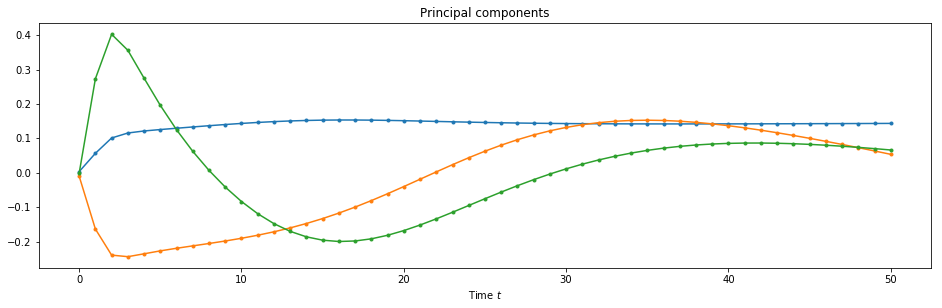

In [8]:
factors=3
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # highest principal component first in the array
princ_eigval = array([eigval[i] for i in index_eigvec])
princ_comp = hstack([eigvec[:,i] for i in index_eigvec])
print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp)
plot(princ_comp, marker='.'), title('Principal components'), xlabel(r'Time $t$');

### Calculate discretized volatility function from principal components

vols shape: (51, 3)


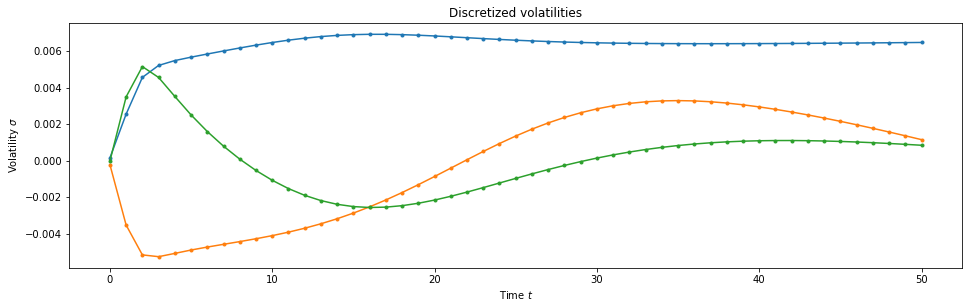

In [9]:
sqrt_eigval = matrix(princ_eigval ** .5)
tmp_m = vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = multiply(tmp_m, princ_comp) # multiply matrice element-wise
print('vols shape: ' + str(vols.shape))
plot(vols, marker='.'), xlabel(r'Time $t$'), ylabel(r'Volatility $\sigma$'), title('Discretized volatilities');

### Volatility Fitting
We need to fit discretized volatility functions from the previous step using cubic interpolators. The reason is that these interpolators will be later integrated numerically in order to calculate risk-neutral drift.

<b>Fit Volatility Functions $\bar{v}(t,\tau)$ from discretized versions</b><br>
<b>Fitting is done using <u>cubic spline</u></b><br>

In [10]:
def get_matrix_column(mat, i):
    return array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params):
        assert type(params) == ndarray
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = array([x**i for i in reversed(range(n))])
        return sum(multiply(X, C))

We will approximate the first principal component with interpolator with 0 degree (straight line). This approximates well parallel movements of interest rates.

In [11]:
fitted_vols = []

2nd and 3rd principal component will be approximated using cubic interpolator with degree 3.

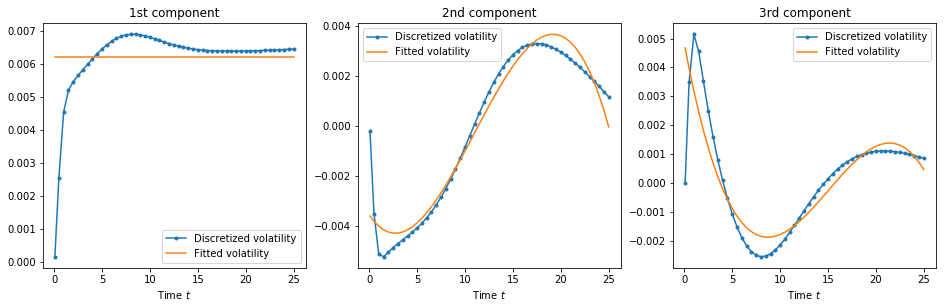

In [12]:
def fit_volatility(i, degree, title):
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(polyfit(tenors, vol, degree))    
    plot(tenors, vol, marker='.', label='Discretized volatility')
    plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title), xlabel(r'Time $t$'), legend();
    fitted_vols.append(fitted_vol)
    
subplot(1, 3, 1), fit_volatility(0, 0, '1st component');
subplot(1, 3, 2), fit_volatility(1, 3, '2nd component');
subplot(1, 3, 3), fit_volatility(2, 3, '3rd component');

### Monte Carlo Simulation

#### Define function for numeric integration
We will use trapezoidal rule:
$$\int_0^t v(\tau)d\tau \approx \sum_{0}^{n} \frac{1}{2}(v_{i+1}-v_i)\times d\tau$$

In [13]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(linspace(x0, x1, n)):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out

#### Discretize fitted volatilities for the purpose of drift calculation

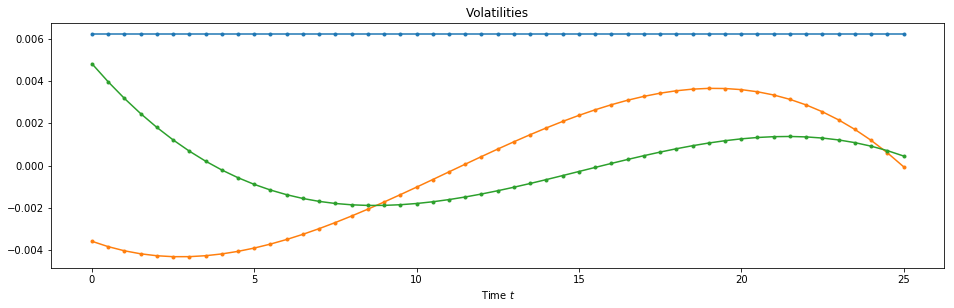

In [14]:
mc_tenors = linspace(0,25,51)
# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols = matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()
plot(mc_tenors, mc_vols, marker='.'), xlabel(r'Time $t$'), title('Volatilities');

#### Drift calculation
Drift $m(t,\tau)$ is calculated using numerical integration over fitted volatility functions (No Mursiela parameterisation for now)<br><br>
$$ m(t,\tau) = \sum_{i=1}^n v_i(t,\tau) \int_0^\tau v_i(t,s)ds $$

In [15]:
def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        assert isinstance(fitted_vol, PolynomialInterpolator)
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

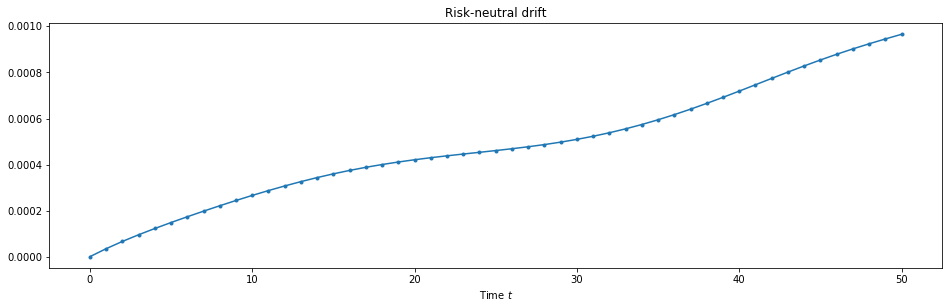

In [16]:
mc_drift = array([m(tau, fitted_vols) for tau in mc_tenors])
plot(mc_drift, marker='.'), xlabel(r'Time $t$'), title('Risk-neutral drift');

#### Perform Monte Carlo Simulation (one path)

Few formulas
$$f(t,T)=F(t;T,T+\delta T)$$
$$df(t,T) = m(t,T)dt + \sum^N_{i=1}v_i(t,T)dX_i$$
$$m(t,T)=\sum^N_{i=1}v_i(t,T)\int_t^Tv_i(t,s)ds$$
Mursiela parameterisation
$$\bar{f}(t,\tau)=f(t,t+\tau)$$

The multi-factor HJM framework is implemented with this SDE:
$$d\bar{f}(t,\tau)=(\sum_{i=1}^k \bar{v}_i(t,\tau)\int_0^\tau {v}_i(t,s)ds+\frac{\delta\bar{f}(t,\tau)}{\delta\tau})dt + \sigma_{i=1}^k \bar{v}_i(t,\tau)dX_i$$

We simulate by $f(t+dt)=f(t) + d\bar{f}$   where Musiela HJM SDE is $d\bar{f} =  m(t)dt+\sum(v_i*\phi*\sqrt{dt})+\frac{dF}{d\tau}dt$

#### today's instantenous forward rates $f(t_0, T)$

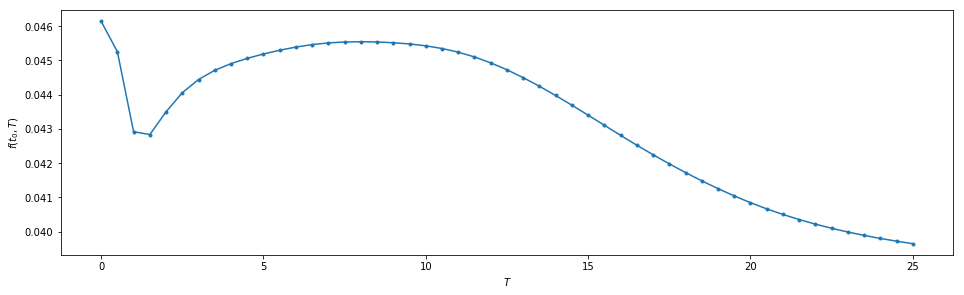

In [17]:
curve_spot = array(hist_rates[-1,:].flatten())[0]
plot(mc_tenors, curve_spot.transpose(), marker='.'), ylabel('$f(t_0,T)$'), xlabel("$T$");

In [18]:
def simulation(f, tenors, drift, vols, timeline):
    assert type(tenors)==ndarray
    assert type(f)==ndarray
    assert type(drift)==ndarray
    assert type(timeline)==ndarray
    assert len(f)==len(tenors)
    vols = array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copylib.copy(f)
    for it in range(1, len(timeline)):
        t = timeline[it]
        dt = t - timeline[it-1]
        sqrt_dt = sqrt(dt)
        fprev = f
        f = copylib.copy(f)
        random_numbers = [normal() for i in range(len_vols)]
        for iT in range(len_tenors):
            val = fprev[iT] + drift[iT] * dt
            #
            sum = 0
            for iVol, vol in enumerate(vols):
                sum += vol[iT] * random_numbers[iVol]
            val += sum * sqrt_dt
            #
            iT1 = iT+1 if iT<len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT)
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

One simulation path 
0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%

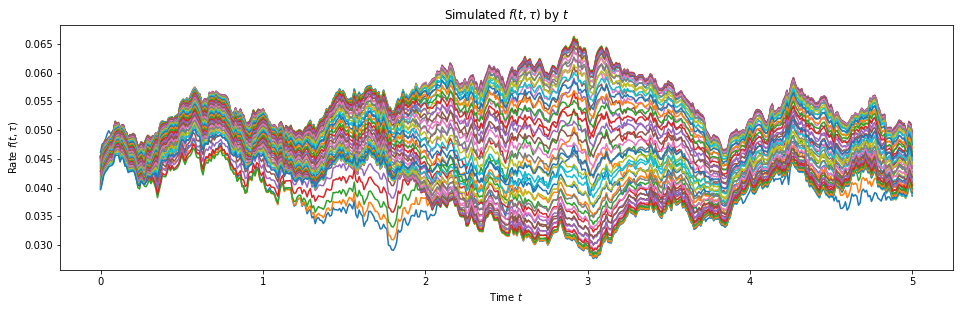

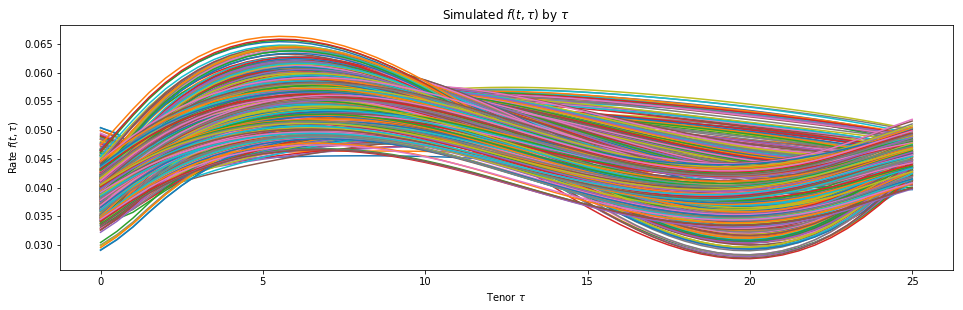

(<matplotlib.text.Text at 0x1b3daa374a8>, None)

In [19]:
proj_rates = []
proj_timeline = linspace(0,5,500)
progressbar = ProgressBar("One simulation path", len(proj_timeline))
for i, (t, f) in enumerate(simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    progressbar.update(i)
    proj_rates.append(f)
proj_rates = matrix(proj_rates)
plot(proj_timeline.transpose(), proj_rates), xlabel(r'Time $t$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $t$'), show()
plot(mc_tenors, proj_rates.transpose()), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $\tau$'), show()

### Pricing of trade using Monte Carlo

#### Define integrator for instatenous rates

Integrating $f(t)$ over $n$ discrete samples:
$$\int_{t_1}^{t_n} f(t)dt \approx \frac{(t_n-t_1)}{n}\sum_{i=1}^n f(t_i)$$
<b>Simple</b> LIBOR forward rate (e.g. 3M libor)
$$F(t_0;t,T) = \int_{t}^{T} f(t_0, s)ds$$

In [20]:
class Integrator:
    def __init__(self, x0, x1):
        assert x0 < x1
        self.sum, self.n, self.x0, self.x1= 0, 0, x0, x1
    def add(self, value):
        self.sum += value
        self.n += 1
    def get_integral(self):
        return (self.x1 - self.x0) * self.sum / self.n

#### Price caplet

Caplet with strike $K=3\%$, expiring in $t_s=1.0$, maturing in $t_e=2.0$, notional $N=1,000,000$

Performing simulation 
0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%

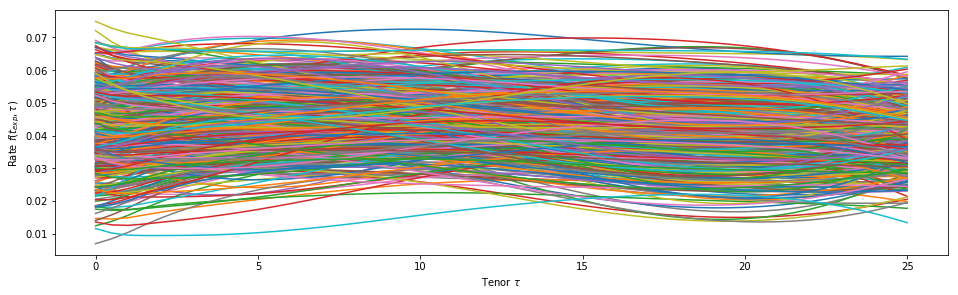

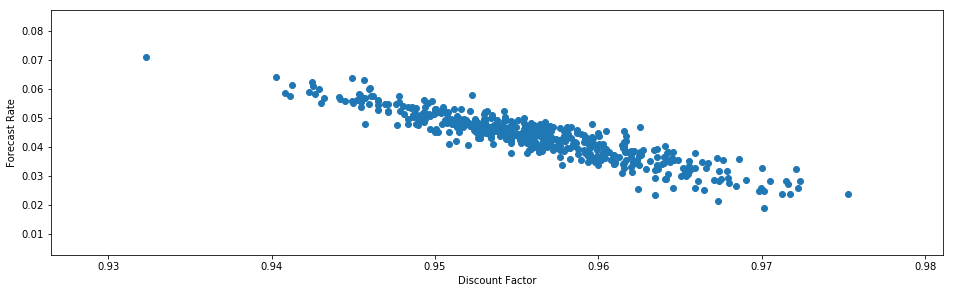

Final value: 13078.429431


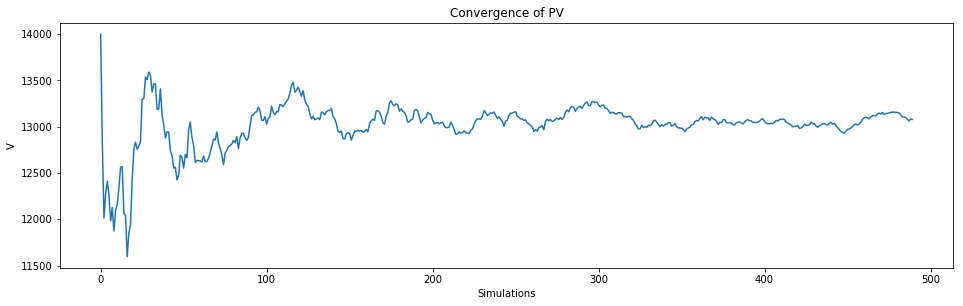

In [21]:
t_exp = 1.
t_mat = 2.
K = .03
notional = 1e6
n_simulations = 500
n_timesteps = 50
proj_timeline = linspace(0,t_mat, n_timesteps)
progressbar = ProgressBar('Performing simulation', n_simulations)
simulated_forecast_rates = []
simulated_df = []
simulated_pvs = []
pv_convergence_process = []
for i in range(0, n_simulations):
    progressbar.update(i)
    rate_forecast = None                    # Forecast rate between t_exp and t_mat for this path
    rate_discount = Integrator(0, t_exp)      # cont.compounded discount rate for this path
    for t, curve_fwd in simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline):
        f_t_0 = interp(0., mc_tenors, curve_fwd)  # rate $f_t^0$
        rate_discount.add(f_t_0)
        if t>=t_exp and rate_forecast is None:  # t is expiration time
            Tau = t_mat-t_exp
            rate_forecast = Integrator(0, Tau) # integrate all inst.fwd.rates from 0 till 1Y tenor to get 1Y spot rate
            for s in linspace(0, Tau, 15): # $\int_0^T f(t,s)ds$
                f_texp_s = interp(s, mc_tenors, curve_fwd)
                rate_forecast.add(f_texp_s) 
            rate_forecast = rate_forecast.get_integral()
    plot(mc_tenors, curve_fwd), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t_{exp},\tau)$');   # Plot forward curve at expiration
    df = exp(-rate_discount.get_integral())     # Discount factor
    simulated_forecast_rates.append(rate_forecast)
    simulated_df.append(df)
    pv = max(0, rate_forecast - K) * (t_mat-t_exp) * notional * df
    simulated_pvs.append(pv)
    pv_convergence_process.append(average(simulated_pvs))
show()
#
scatter(simulated_df, simulated_forecast_rates), xlabel('Discount Factor'), ylabel('Forecast Rate')
show()
#
plot(pv_convergence_process[10:]), title('Convergence of PV'), xlabel("Simulations"), ylabel("V");
print("Final value: %f" % pv_convergence_process[-1])